# Interpreting the Weather Model

This is part two of the three part interpretation assignment:
1. [Interpretation and Significance](https://github.com/philbowman212/Thinkful_repo/blob/master/assignments/3_supervised_learning/regression_problems/interp_significance_assignment.md)
2. [Interpreting the Weather](https://github.com/philbowman212/Thinkful_repo/blob/master/assignments/3_supervised_learning/regression_problems/interpreting_temp.ipynb)
3. [Interpreting the House Prices](https://github.com/philbowman212/Thinkful_repo/blob/master/assignments/3_supervised_learning/regression_problems/interpreting_house_prices.ipynb)

### Weather model

In this exercise, you'll work with the historical temperature data from the previous checkpoint. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* First, load the dataset from the **weatherinszeged** table from Thinkful's database.
* Build a linear regression model where your target variable is the difference between the *apparenttemperature* and the *temperature*. As explanatory variables, use *humidity* and *windspeed*. Now, estimate your model using OLS. Are the estimated coefficients statistically significant? Are the signs of the estimated coefficients in line with your previous expectations? Interpret the estimated coefficients. What are the relations between the target and the explanatory variables? 
* Next, include the interaction of *humidity* and *windspeed* to the model above and estimate the model using OLS. Are the coefficients statistically significant? Did the signs of the estimated coefficients for *humidity* and *windspeed* change? Interpret the estimated coefficients.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [28]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from weatherinszeged',con=engine)

engine.dispose()

In [29]:
df['temp_diff'] = df.apparenttemperature.copy() - df.temperature.copy()

In [30]:
data = df[['temp_diff', 'humidity', 'windspeed']].copy()

In [31]:
data.describe()

,temp_diff,humidity,windspeed
count,96453.000000,96453.000000,96453.000000
mean,-1.077650,0.734899,10.810640
std,1.678694,0.195473,6.913571
min,-10.183333,0.000000,0.000000
25%,-2.216667,0.600000,5.828200
50%,0.000000,0.780000,9.965900
75%,0.000000,0.890000,14.135800
max,4.811111,1.000000,63.852600


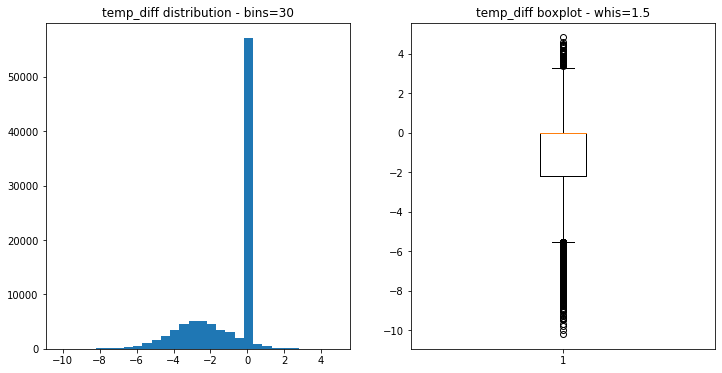

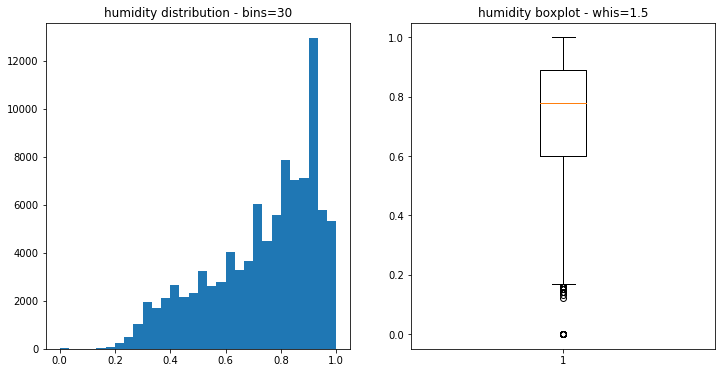

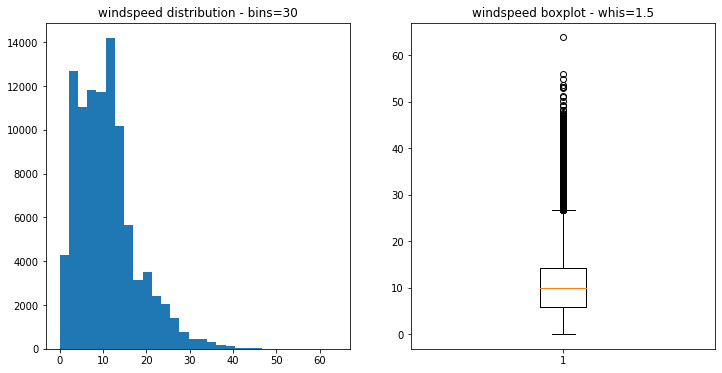

In [32]:
def hist_box(data=data, columns=data.columns):
    for col in columns:
        plt.figure(figsize=(12,6))
        plt.subplot(121)
        plt.hist(data[col], bins=30)
        plt.title('{} distribution - bins=30'.format(col))
        plt.subplot(122)
        plt.boxplot(data[col])
        plt.title('{} boxplot - whis=1.5'.format(col))
        plt.show()
hist_box(data, data.columns)

In [33]:
def outliers_std(data=data, columns=data.columns, thresh=2):
    outlier_indexes = []
    for col in columns:
        ser_col = data[col]
        mean = ser_col.mean()
        sd = ser_col.std()
        outliers_mask = data[(data[col] > mean + thresh*sd) | (data[col] < mean - thresh*sd)].index
        outlier_indexes += [x for x in outliers_mask]
    return list(set(outlier_indexes))

In [34]:
def outliers_iqr(data=data, columns=data.columns, thresh=1.5):
    outlier_indexes = []
    for col in columns:
        q25, q75 = np.percentile(data[col], [25, 75])
        iqr = q75 - q25
        upper_lim = q75 + (iqr*thresh)
        lower_lim = q25 - (iqr*thresh)
        outliers_mask = data[(data[col] >= upper_lim) | (data[col] <= lower_lim)].index
        outlier_indexes += [x for x in outliers_mask]
    return list(set(outlier_indexes))

In [35]:
len(outliers_std()), len(outliers_iqr())

(12375, 4185)

Eliminate outliers...

In [36]:
data.drop(outliers_iqr(), inplace=True)

In [37]:
X_data = data.iloc[:, 1:]
target = data.iloc[:, 0]

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, target, test_size=.3, random_state=21)

In [40]:
from sklearn import linear_model

In [41]:
lm = linear_model.LinearRegression()
lm.fit(X_train, Y_train)
Y_pred = lm.predict(X_test)

In [42]:
from sklearn import metrics
def evaluate(Y_test, Y_pred):
    mse = metrics.mean_squared_error(Y_test, Y_pred)
    msa = metrics.mean_absolute_error(Y_test, Y_pred)
    r2 = metrics.r2_score(Y_test, Y_pred)
    
    print('Mean squared error:', mse)
    print('Mean absolute error:', msa)
    print('R^2:', r2)
    
    plt.scatter(Y_test, Y_pred)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')

Mean squared error: 1.6726229026828376
Mean absolute error: 1.055424195265563
R^2: 0.25562584282169787


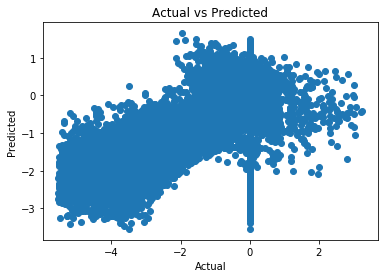

In [43]:
evaluate(Y_test, Y_pred)

In [44]:
lm.coef_, lm.intercept_

(array([-2.85096489, -0.11339056]), 2.2783312128595634)

In [45]:
import statsmodels.api as sm

In [46]:
sm_X_train = sm.add_constant(X_train)
results = sm.OLS(Y_train, sm_X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              temp_diff   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                 1.091e+04
Date:                Sun, 10 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:09:09   Log-Likelihood:            -1.0852e+05
No. Observations:               64587   AIC:                         2.170e+05
Df Residuals:                   64584   BIC:                         2.171e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2783      0.024     94.114      0.0

It appears that for this model, all the features are significant.

The equation for this model is as follows:

$$ temp\_di\!f\!f = 2.2783 - 2.8510humidity - 0.1134windspeed $$

So the difference between apparent temperature and temperature can be modeled by the equation above. A general interpretation of the coefficients will now be conducted:
- constant - if all other variables were 0, then bias would be 2.2783
- humidity - if humidity were 100%, then the difference in temp would go down by 2.8510 degrees
- windspeed - for each mph of windspeed the difference in temps would go down by 0.1134 degrees

### Add relation of windspeed and humidity to the model

In [47]:
X_data['hum_wind_rel'] = X_data.humidity.copy() * X_data.windspeed.copy()

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, target, test_size=.3, random_state=21)

In [49]:
lm = linear_model.LinearRegression()
lm.fit(X_train, Y_train)
Y_pred = lm.predict(X_test)

Mean squared error: 1.554502041974784
Mean absolute error: 0.9566388925682535
R^2: 0.30819364874717103


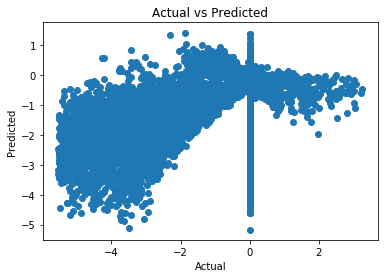

In [50]:
evaluate(Y_test, Y_pred)

In [51]:
lm.coef_, lm.intercept_

(array([ 0.52252577,  0.12451909, -0.3313973 ]), -0.23288829011671075)

In [52]:
sm_X_train = sm.add_constant(X_train)
results = sm.OLS(Y_train, sm_X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              temp_diff   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     9753.
Date:                Sun, 10 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:09:11   Log-Likelihood:            -1.0585e+05
No. Observations:               64587   AIC:                         2.117e+05
Df Residuals:                   64583   BIC:                         2.117e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.2329      0.041     -5.696   

Everything is still significant, new equation:
$$ temp\_di\!f\!f = -0.2329 + 0.5225humidity + 0.1245windspeed - 0.3314hum\_wind\_rel$$

For one percent increase in humidity, there is a decrease of 0.0279 in the differences of the temperatures.

For a one mile per hour increase in windspeed, there is a decrease of 0.0743 in the differences of the temperatures. 